In [69]:
from IPython.display import display, Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

<span style="font-size: 20px; font-weight: bold;">1.Implementation of Harris algorithm using OpenCV</span>


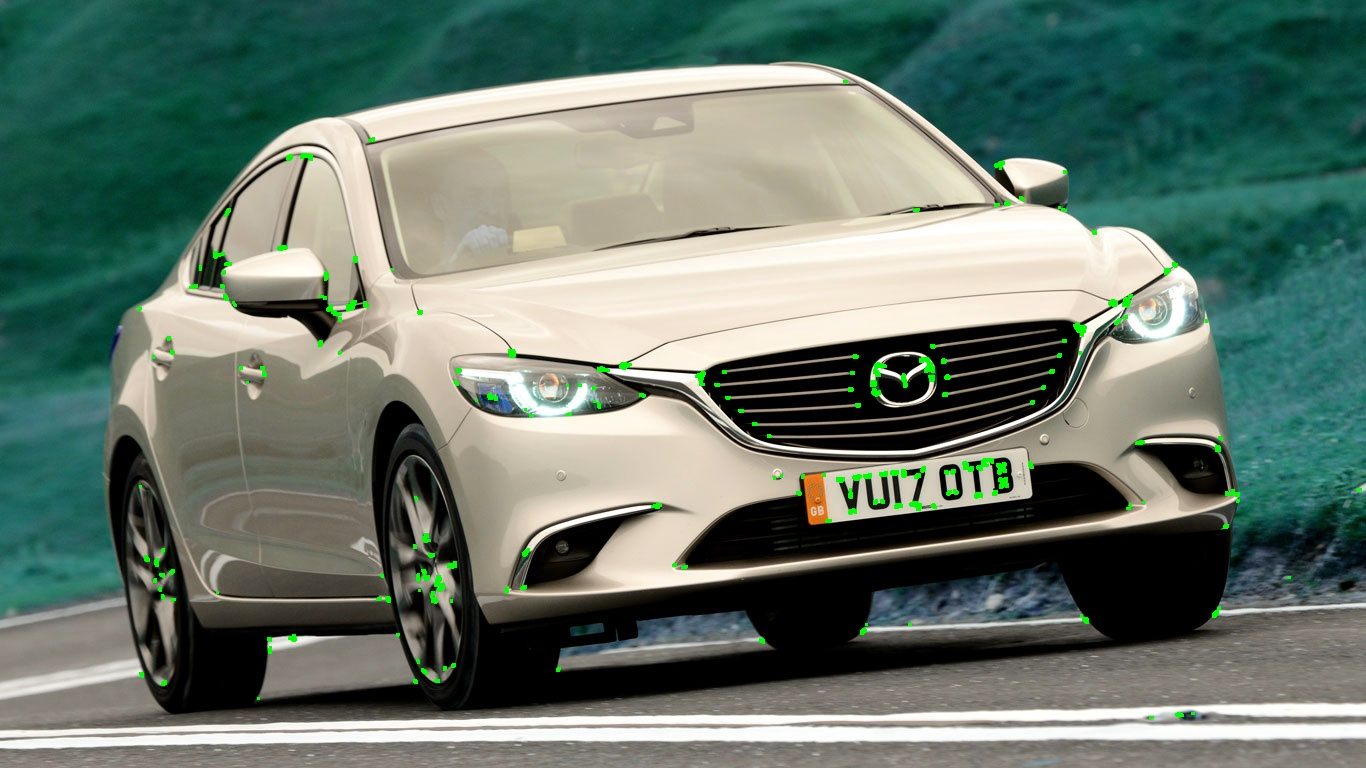

In [70]:

img = cv2.imread('./car.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
dst = cv2.cornerHarris(gray, blockSize=3, ksize=5, k=0.05)
dst = cv2.dilate(dst, None)
threshold = 0.01 * dst.max()
img[dst > threshold] = [0, 255, 0]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(Image(data=cv2.imencode('.jpg', img_rgb)[1].tobytes()))


<span style="font-size: 20px; font-weight: bold;">2.Implementation of Image Pyramid using OpenCV</span>


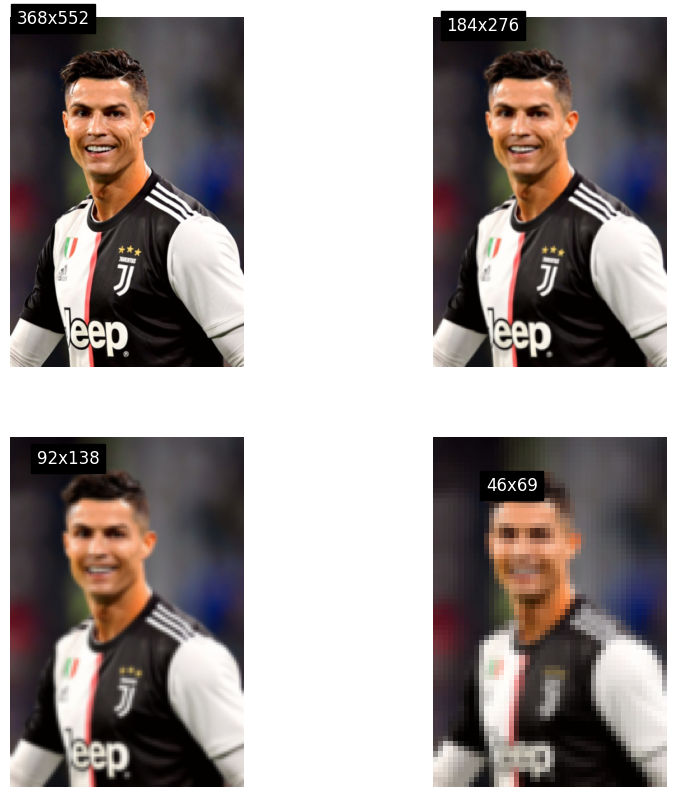

In [71]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("CR7.jpg")
layer = img.copy()

plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    layer = cv2.pyrDown(layer)
    layer_rgb = cv2.cvtColor(layer, cv2.COLOR_BGR2RGB)
    plt.imshow(layer_rgb)
    plt.axis('off')
    height, width, _ = layer.shape
    plt.text(10, 10, f'{width}x{height}', color='white', fontsize=12, backgroundcolor='black')

plt.show()

cv2.destroyAllWindows()


<span style="font-size: 20px; font-weight: bold;">3.Implementing  Image Segmentation with Watershed Algorithm using OpenCV</span>


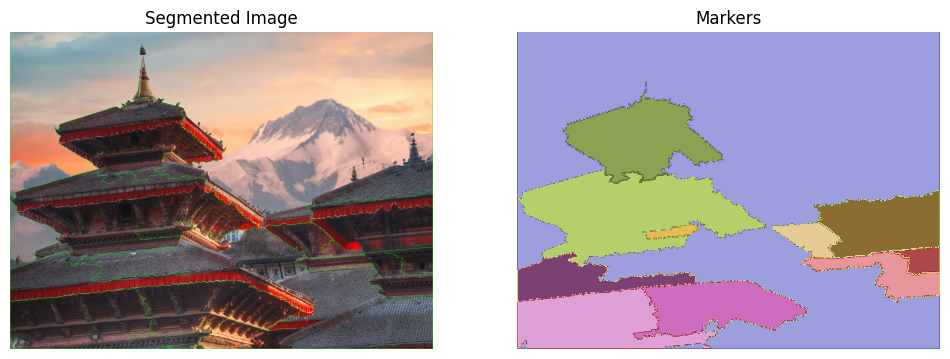

In [72]:

# Load the image
# image = cv2.imread('./coin2.png')
image = cv2.imread('./temple2.webp')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to obtain a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using morphological opening with a different kernel size
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

# Sure background area with different dilation iterations
sure_bg = cv2.dilate(opening, kernel, iterations=5)

# Finding sure foreground area with different distance transform parameters
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
_, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark unknown region with 0
markers[unknown == 255] = 0

# Apply watershed algorithm
markers = cv2.watershed(image, markers)
image[markers == -1] = [0, 255, 0]  # Mark watershed boundaries in green

# Display the result using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the segmented image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Segmented Image')
axes[0].axis('off')

# Display the markers
axes[1].imshow(markers, cmap='tab20b')
axes[1].set_title('Markers')
axes[1].axis('off')

plt.show()


<span style="font-size: 20px; font-weight: bold;">4.Implement SIFT algorithm using OpenCV</span>


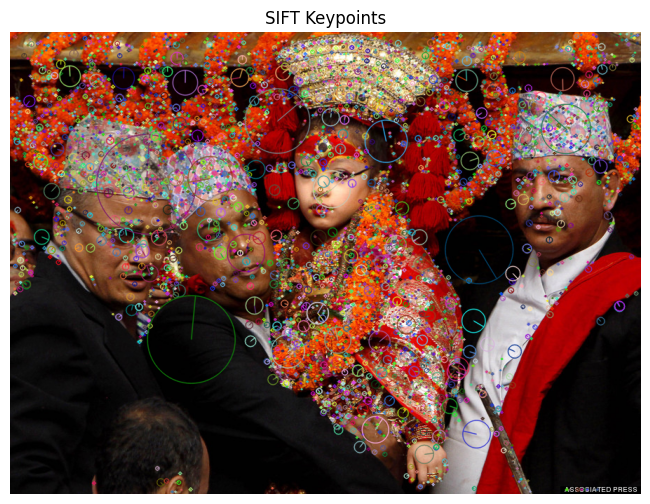

In [73]:

img = cv2.imread('./kumari.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()


<span style="font-size: 20px; font-weight: bold;">5.Implement object detection using YOLO on the COCO dataset. Provide the 
results for any 5 images (for testing purposes) from the dataset.</span>


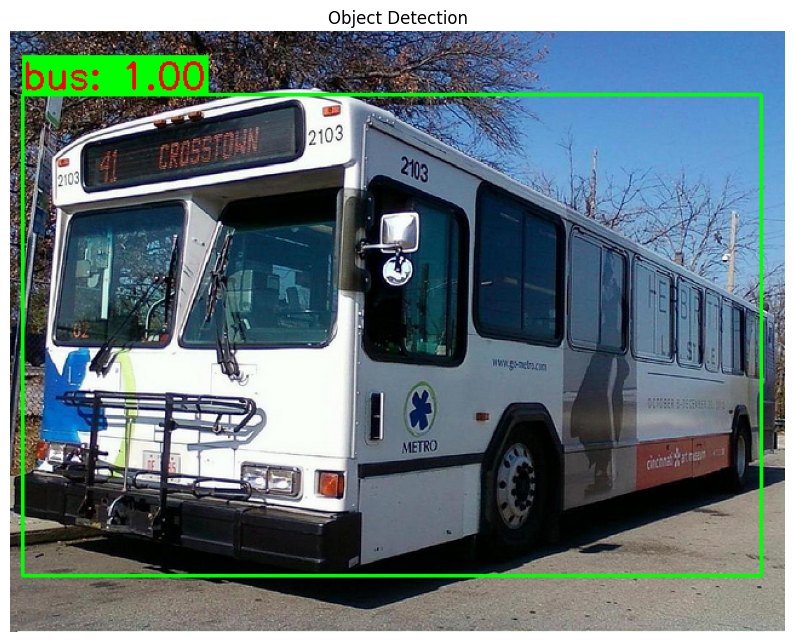

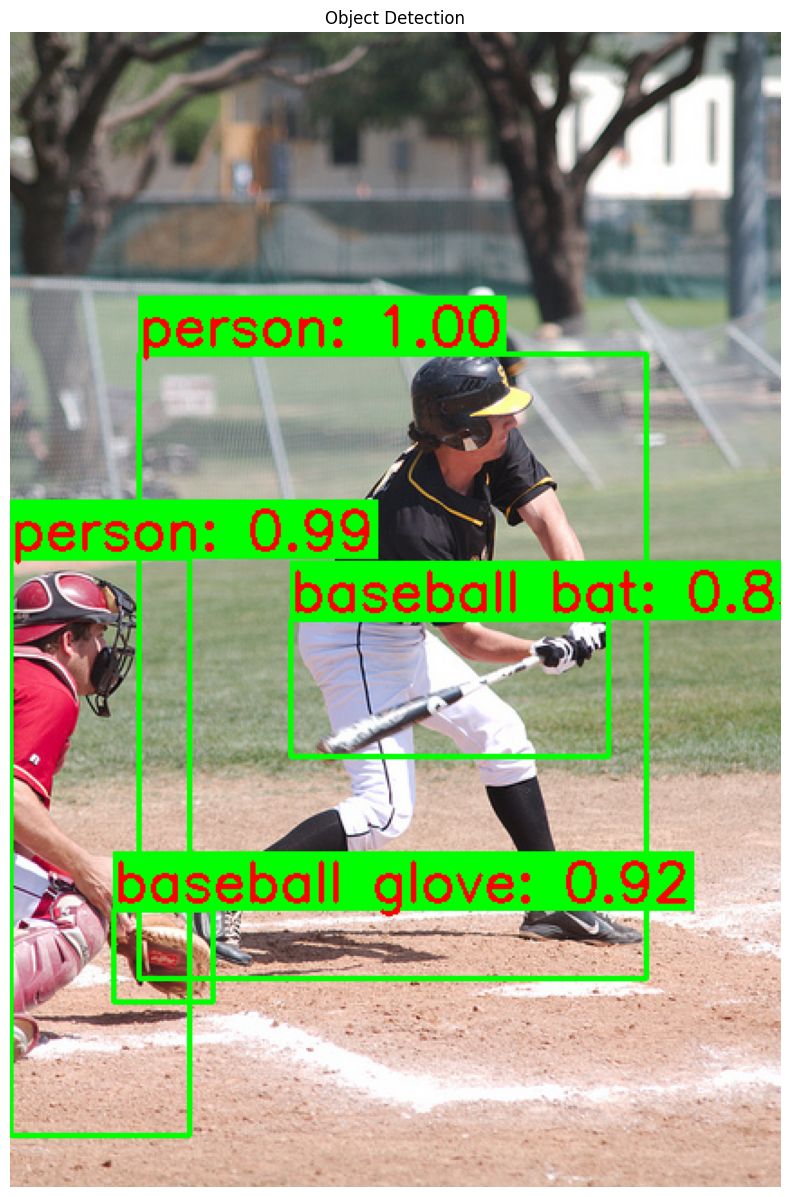

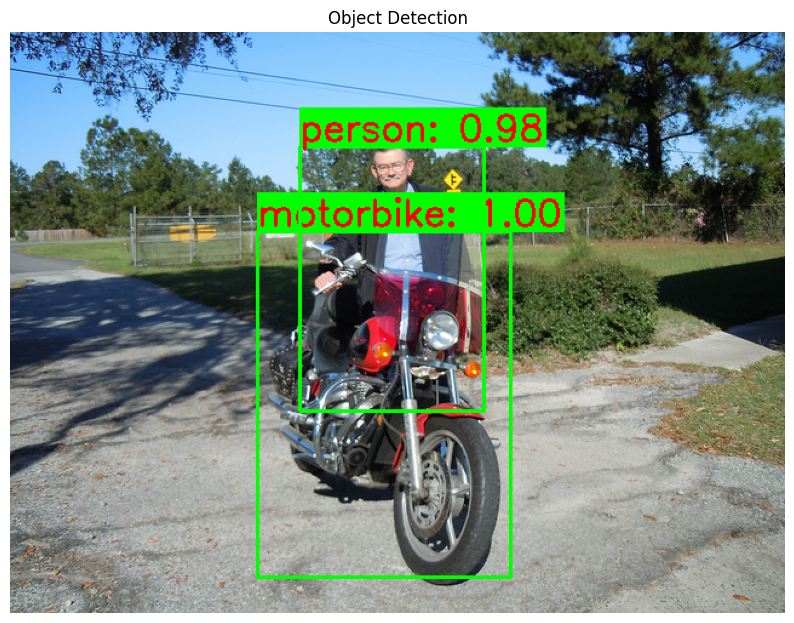

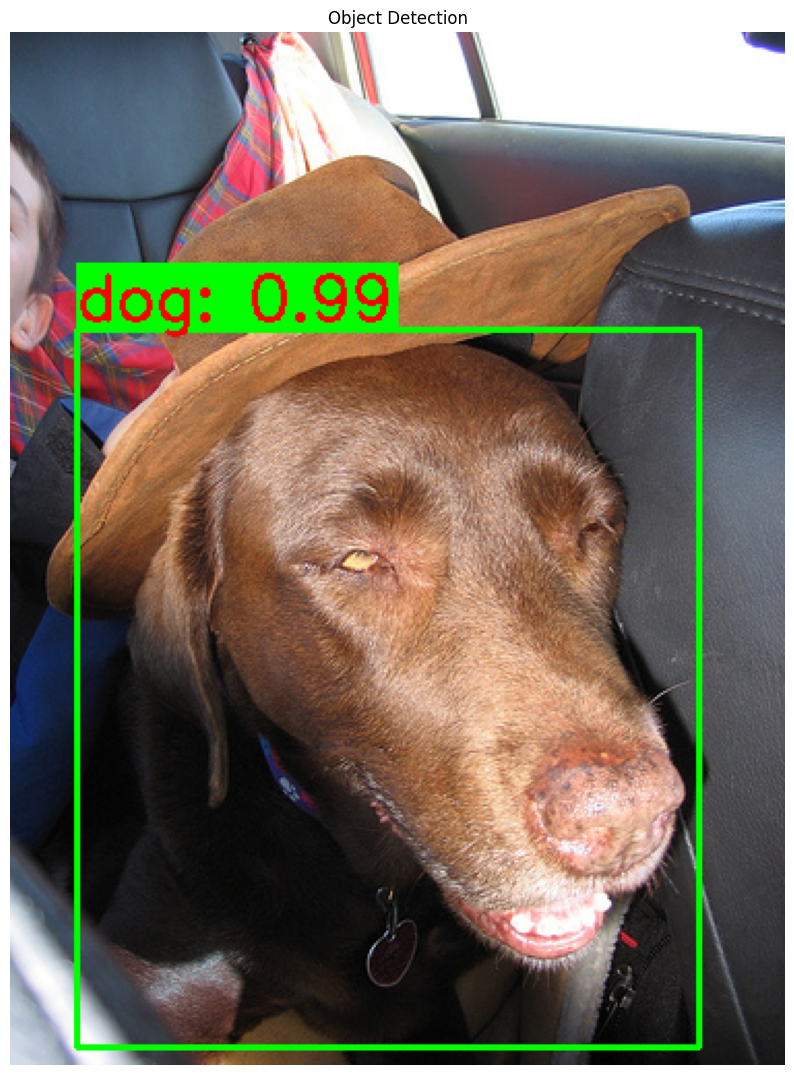

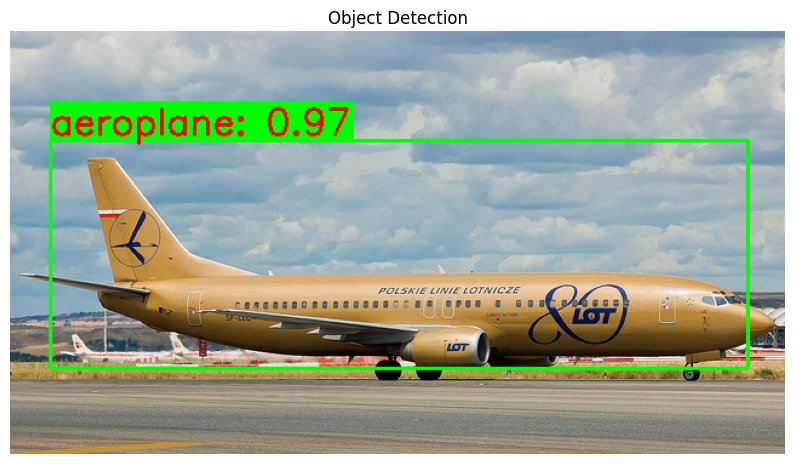

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

if net.empty():
    print("Error: Unable to load YOLOv3 model.")
    exit()

with open('coco.names', 'r') as f:
    class_labels = f.read().strip().split('\n')

image_paths = ['./bus.jpg', './baseball.jpg', './person_bike.jpg', './dog.jpg','./jet.jpg']

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

for image_path in image_paths:
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        continue
    
    height, width, channels = image.shape

    blob = cv2.dnn.blobFromImage(image, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []
    
    for out in outs:
        for detection in out:
            if len(detection.shape) == 1:
                detection = detection.reshape(1, -1)
            for obj in detection:
                if len(obj) < 85:
                    continue
                scores = obj[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > 0.85:
                    center_x = int(obj[0] * width)
                    center_y = int(obj[1] * height)
                    w = int(obj[2] * width)
                    h = int(obj[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.85, nms_threshold=0.4)

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = class_labels[class_ids[i]]
            confidence = confidences[i]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = f"{label}: {confidence:.2f}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.rectangle(image, (x, y - text_height - 10), (x + text_width, y), (0, 255, 0), cv2.FILLED)
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 15))
    plt.imshow(image_rgb)
    plt.title('Object Detection')
    plt.axis('off')
    plt.show()
